# **MLOps Assignment: Cat vs Dog Classification**

---

## Use Case : Binary Image Classification for Pet Adoption Platform



---

## Module M1: Model Development & Experiment Tracking

---

## I. Data

In [ ]:
# 1. Library Installations

!pip install mlflow
!pip install dvc
!pip install tensorflow
!pip install pillow
!pip install scikit-learn
!pip install seaborn

  Using cached dvc-3.66.1-py3-none-any.whl.metadata (17 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.7/469.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.5/445.5 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.2/214.2 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 41.8 MB/s

In [ ]:
# 2. Mounting drive to save results

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 3. Import Libraries


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.keras
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import shutil
import glob
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2, EfficientNetB0  # Better than ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# 4. Download Kaggle Dataset

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d bhavikjikadara/dog-and-cat-classification-dataset

!unzip -q dog-and-cat-classification-dataset.zip -d /content/raw_data

print("Dataset downloaded and extracted successfully!")


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset
License(s): apache-2.0
 96% 743M/775M [00:03<00:00, 243MB/s]
100% 775M/775M [00:03<00:00, 231MB/s]
Dataset downloaded and extracted successfully!


In [ ]:
# 5. Data Split
# Following Requirements: 80% Train / 10% Validation / 10% Test

base_dir = '/content/dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(directory, 'cats'), exist_ok=True)
    os.makedirs(os.path.join(directory, 'dogs'), exist_ok=True)

print("Directory structure created!")


Directory structure created!


In [ ]:
cat_source = glob.glob('/content/raw_data/PetImages/Cat/*.jpg')
dog_source = glob.glob('/content/raw_data/PetImages/Dog/*.jpg')

cat_images = cat_source
dog_images = dog_source

print(f"Total cats: {len(cat_images)}")
print(f"Total dogs: {len(dog_images)}")

# Split cats: 80% train, 10% val, 10% test
cat_train, cat_temp = train_test_split(cat_images, test_size=0.2, random_state=42)
cat_val, cat_test = train_test_split(cat_temp, test_size=0.5, random_state=42)

# Split dogs: 80% train, 10% val, 10% test
dog_train, dog_temp = train_test_split(dog_images, test_size=0.2, random_state=42)
dog_val, dog_test = train_test_split(dog_temp, test_size=0.5, random_state=42)

print(f"\nDataset Split (80/10/10):")
print(f"Train: {len(cat_train)} cats + {len(dog_train)} dogs = {len(cat_train) + len(dog_train)} total")
print(f"Val:   {len(cat_val)} cats + {len(dog_val)} dogs = {len(cat_val) + len(dog_val)} total")
print(f"Test:  {len(cat_test)} cats + {len(dog_test)} dogs = {len(cat_test) + len(dog_test)} total")

def copy_files(file_list, destination):
    """Copy files to destination directory"""
    for i, file in enumerate(file_list):
        shutil.copy(file, destination)

print("\nCopying files to train/val/test directories...")
copy_files(cat_train, os.path.join(train_dir, 'cats'))
copy_files(dog_train, os.path.join(train_dir, 'dogs'))
copy_files(cat_val, os.path.join(val_dir, 'cats'))
copy_files(dog_val, os.path.join(val_dir, 'dogs'))
copy_files(cat_test, os.path.join(test_dir, 'cats'))
copy_files(dog_test, os.path.join(test_dir, 'dogs'))

print("Dataset split complete! (80% train, 10% val, 10% test)")

Total cats: 12499
Total dogs: 12499

Dataset Split (80/10/10):
Train: 9999 cats + 9999 dogs = 19998 total
Val:   1250 cats + 1250 dogs = 2500 total
Test:  1250 cats + 1250 dogs = 2500 total

Copying files to train/val/test directories...
Dataset split complete! (80% train, 10% val, 10% test)


Found 19998 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Data preprocessing complete!
All images preprocessed to 224x224 RGB format
Data augmentation applied to training set for better generalization

 Dataset Statistics:
Training samples: 19998
Validation samples: 2500
Test samples: 2500
Class indices: {'cats': 0, 'dogs': 1}

Sample augmented images:


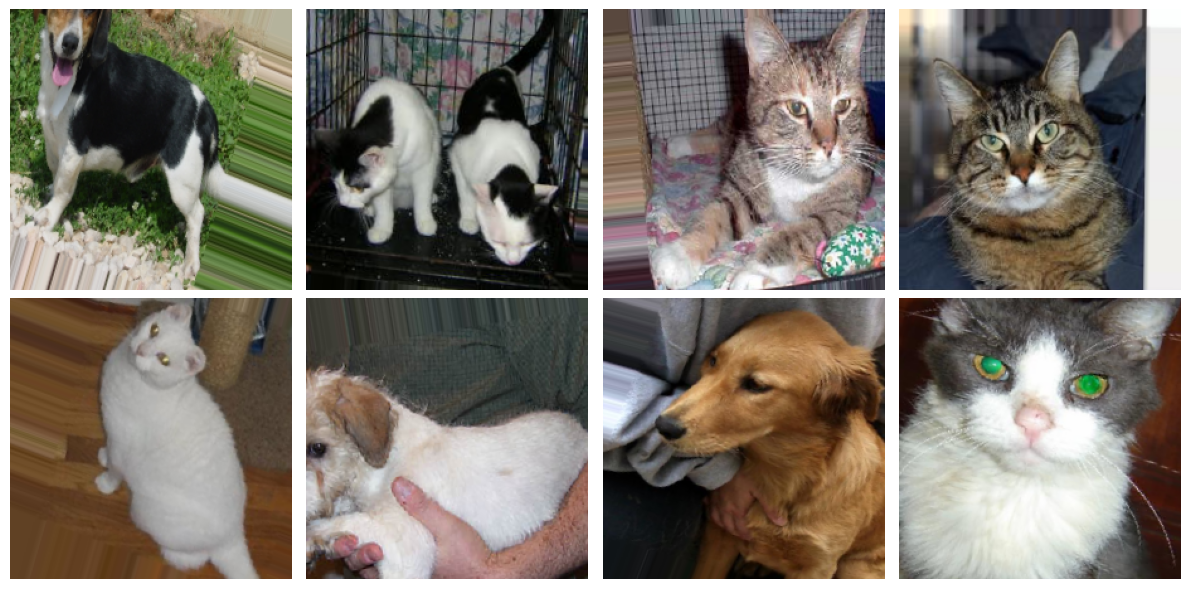

In [ ]:
# 6. Data Preprocessing to 224x224 RGB

IMG_SIZE = 224
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize to [0,1]
    rotation_range=20,        # Random rotation
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    horizontal_flip=True,     # Random horizontal flip
    zoom_range=0.2,           # Random zoom
    shear_range=0.2,          # Shear transformation
    fill_mode='nearest'       # Fill pixels after transformation
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

print("Data preprocessing complete!")
print(f"All images preprocessed to {IMG_SIZE}x{IMG_SIZE} RGB format")
print(f"Data augmentation applied to training set for better generalization")
print(f"\n Dataset Statistics:")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

# Visualization
print("\nSample augmented images:")
sample_batch = next(train_generator)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(sample_batch[0]):
        ax.imshow(sample_batch[0][i])
        ax.axis('off')
plt.tight_layout()
plt.savefig('/content/sample_augmented_images.png', dpi=150)
plt.show()


In [ ]:
# ============================================
# Check Class Balance in Dataset
# ============================================

import os

def count_images_per_class(directory):
    cats = len(os.listdir(os.path.join(directory, 'cats')))
    dogs = len(os.listdir(os.path.join(directory, 'dogs')))
    return cats, dogs

# Count in each split
train_cats, train_dogs = count_images_per_class(train_dir)
val_cats, val_dogs = count_images_per_class(val_dir)
test_cats, test_dogs = count_images_per_class(test_dir)

print("CLASS BALANCE CHECK")
print(f"\nTraining Set:")
print(f"  Cats: {train_cats} ({train_cats/(train_cats+train_dogs)*100:.1f}%)")
print(f"  Dogs: {train_dogs} ({train_dogs/(train_cats+train_dogs)*100:.1f}%)")
print(f"  Total: {train_cats + train_dogs}")
print(f"  Balance Ratio: {train_cats/train_dogs:.2f}")

print(f"\nValidation Set:")
print(f"  Cats: {val_cats} ({val_cats/(val_cats+val_dogs)*100:.1f}%)")
print(f"  Dogs: {val_dogs} ({val_dogs/(val_cats+val_dogs)*100:.1f}%)")
print(f"  Total: {val_cats + val_dogs}")
print(f"  Balance Ratio: {val_cats/val_dogs:.2f}")

print(f"\nTest Set:")
print(f"  Cats: {test_cats} ({test_cats/(test_cats+test_dogs)*100:.1f}%)")
print(f"  Dogs: {test_dogs} ({test_dogs/(test_cats+test_dogs)*100:.1f}%)")
print(f"  Total: {test_cats + test_dogs}")
print(f"  Balance Ratio: {test_cats/test_dogs:.2f}")

# Check if balanced (within 5% tolerance)
overall_balance = abs(train_cats - train_dogs) / (train_cats + train_dogs)
if overall_balance < 0.05:
    print(f"\n Dataset is BALANCED (difference < 5%)")
else:
    print(f"\n WARNING: Dataset may be IMBALANCED (difference = {overall_balance*100:.1f}%)")


CLASS BALANCE CHECK

Training Set:
  Cats: 9999 (50.0%)
  Dogs: 9999 (50.0%)
  Total: 19998
  Balance Ratio: 1.00

Validation Set:
  Cats: 1250 (50.0%)
  Dogs: 1250 (50.0%)
  Total: 2500
  Balance Ratio: 1.00

Test Set:
  Cats: 1250 (50.0%)
  Dogs: 1250 (50.0%)
  Total: 2500
  Balance Ratio: 1.00

 Dataset is BALANCED (difference < 5%)


In [ ]:
# DATA LOADERS

import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

DATA_DIR = '/content/dataset'
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'validation')
test_dir = os.path.join(DATA_DIR, 'test')

model_save_path = '/content/drive/MyDrive/mlops_project/models'
os.makedirs(model_save_path, exist_ok=True)

IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
print(f"Class indices: {train_dataset.class_to_idx}")

Train: 19998 | Val: 2500 | Test: 2500
Class indices: {'cats': 0, 'dogs': 1}


## II. Model Building

In [ ]:
# EXPERIMENT 1: SIMPLE CNN MODEL BUILDING

import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(SimpleCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


def build_simple_cnn_baseline(num_classes=1):
    model = SimpleCNN(num_classes=num_classes)
    return model


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = build_simple_cnn_baseline(num_classes=1)

print("\nEXPERIMENT 1: Simple CNN Baseline")
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

model = model.to(device)
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
with torch.no_grad():
    output = model(dummy_input)
print(f"Test forward pass successful")
print(f"Input shape: {dummy_input.shape}, Output shape: {output.shape}")

del model
torch.cuda.empty_cache()

Using device: cuda

EXPERIMENT 1: Simple CNN Baseline
SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=512, bias=True)
    (2): ReLU(inp

## III. MLflow Experiment Tracking

In [ ]:
# # 3.1 Setup MLflow Experiment Tracking

# ==========================================
# CELL: MLFLOW EXPERIMENT TRACKING SETUP
# ==========================================

import mlflow
import mlflow.pytorch  # Use pytorch instead of keras!

# Setup MLflow tracking
mlflow_dir = '/content/drive/MyDrive/mlops_project/mlruns'
os.makedirs(mlflow_dir, exist_ok=True)
mlflow.set_tracking_uri(f"file://{mlflow_dir}")

# Set experiment name
experiment_name = "pet-adoption-cat-dog-classification-pytorch"  # Changed name
mlflow.set_experiment(experiment_name)

print("✅ MLflow experiment tracking setup complete!")
print(f"   Experiment: {experiment_name}")
print(f"   MLflow data location: {mlflow_dir}")
print(f"   Framework: PyTorch")

✅ MLflow experiment tracking setup complete!
   Experiment: pet-adoption-cat-dog-classification-pytorch
   MLflow data location: /content/drive/MyDrive/mlops_project/mlruns
   Framework: PyTorch


---
## EXPERIMENT 1: Baseline ResNet50 Model
---

In [ ]:
EPOCHS = 15
LEARNING_RATE = 0.0001
DROPOUT = 0.5

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc='Training'):
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    return epoch_loss, epoch_acc, precision, recall, f1


run_name = f"simple_cnn_baseline_exp1_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

with mlflow.start_run(run_name=run_name):

    print(f"EXPERIMENT 1: Simple CNN Baseline")
    print(f"Run: {run_name}")

    mlflow.log_param("experiment", "Exp1_SimpleCNN_Baseline")
    mlflow.log_param("use_case", "Pet Adoption Platform - Binary Classification")
    mlflow.log_param("framework", "PyTorch")
    mlflow.log_param("model_architecture", "SimpleCNN-FromScratch")
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("image_size", f"{IMG_SIZE}x{IMG_SIZE}")
    mlflow.log_param("dropout", DROPOUT)
    mlflow.log_param("pretrained_weights", "No")
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("gradient_clipping", "1.0")

    model = build_simple_cnn_baseline(num_classes=1)
    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters())
    mlflow.log_param("total_parameters", total_params)
    mlflow.log_param("trainable_parameters", total_params)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6
    )

    print("\nTraining simple CNN baseline...")
    best_val_acc = 0.0
    patience_counter = 0
    early_stopping_patience = 5

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )

        val_loss, val_acc, val_prec, val_rec, val_f1 = validate(
            model, val_loader, criterion, device
        )

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_prec)
        history['val_recall'].append(val_rec)
        history['val_f1'].append(val_f1)

        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)
        mlflow.log_metric("val_precision", val_prec, step=epoch)
        mlflow.log_metric("val_recall", val_rec, step=epoch)
        mlflow.log_metric("val_f1_score", val_f1, step=epoch)
        mlflow.log_metric("learning_rate", current_lr, step=epoch)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
        print(f"Val Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_path = os.path.join(model_save_path, f"{run_name}_best.pt")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, best_model_path)
            print(f"Best model saved! Val Acc: {val_acc*100:.2f}%")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs")
                break

    print("\nEvaluating on test set...")

    checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    test_loss, test_accuracy, test_precision, test_recall, test_f1 = validate(
        model, test_loader, criterion, device
    )

    print(f"\nTest Results:")
    print(f"Accuracy:  {test_accuracy*100:.2f}%")
    print(f"Precision: {test_precision*100:.2f}%")
    print(f"Recall:    {test_recall*100:.2f}%")
    print(f"F1-Score:  {test_f1*100:.2f}%")

    mlflow.log_metric("final_train_accuracy", history['train_acc'][-1])
    mlflow.log_metric("final_val_accuracy", max(history['val_acc']))
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1_score", test_f1)

    model_filename = f"{run_name}.pt"
    final_model_path = os.path.join(model_save_path, model_filename)

    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': 'simple_cnn_baseline',
        'num_classes': 1,
        'img_size': IMG_SIZE,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'class_names': ['cat', 'dog'],
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225],
        'experiment': 'baseline',
        'strategy': 'simple_cnn_from_scratch'
    }, final_model_path)

    print(f"\nModel saved: {model_filename}")

    mlflow.pytorch.log_model(model, "model")

    print(f"\nExperiment 1 Complete - Test Accuracy: {test_accuracy*100:.2f}%")

EXPERIMENT 1: Simple CNN Baseline
Run: simple_cnn_baseline_exp1_20260217_053749

Training simple CNN baseline...

Epoch 1/15


Validation:  92%|█████████▏| 73/79 [00:09<00:00,  7.33it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.06it/s]


Train Loss: 0.6626 | Train Acc: 58.65%
Val Loss: 0.5859 | Val Acc: 68.80%
Val Prec: 0.7072 | Rec: 0.6416 | F1: 0.6728
Best model saved! Val Acc: 68.80%

Epoch 2/15


Validation:  92%|█████████▏| 73/79 [00:07<00:00,  9.70it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:08<00:00,  9.60it/s]


Train Loss: 0.6048 | Train Acc: 66.89%
Val Loss: 0.5380 | Val Acc: 74.28%
Val Prec: 0.7707 | Rec: 0.6912 | F1: 0.7288
Best model saved! Val Acc: 74.28%

Epoch 3/15


Validation:  91%|█████████ | 72/79 [00:09<00:00,  9.20it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.00it/s]


Train Loss: 0.5674 | Train Acc: 70.81%
Val Loss: 0.5062 | Val Acc: 75.04%
Val Prec: 0.8214 | Rec: 0.6400 | F1: 0.7194
Best model saved! Val Acc: 75.04%

Epoch 4/15


Validation:  92%|█████████▏| 73/79 [00:09<00:00,  9.28it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:10<00:00,  7.83it/s]


Train Loss: 0.5215 | Train Acc: 74.04%
Val Loss: 0.4363 | Val Acc: 79.04%
Val Prec: 0.7775 | Rec: 0.8136 | F1: 0.7952
Best model saved! Val Acc: 79.04%

Epoch 5/15


Validation:  94%|█████████▎| 74/79 [00:08<00:00,  6.68it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.38it/s]


Train Loss: 0.4870 | Train Acc: 76.66%
Val Loss: 0.4208 | Val Acc: 80.68%
Val Prec: 0.8151 | Rec: 0.7936 | F1: 0.8042
Best model saved! Val Acc: 80.68%

Epoch 6/15


Validation:  91%|█████████ | 72/79 [00:07<00:00,  9.51it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:08<00:00,  9.69it/s]


Train Loss: 0.4577 | Train Acc: 78.47%
Val Loss: 0.3966 | Val Acc: 81.96%
Val Prec: 0.8423 | Rec: 0.7864 | F1: 0.8134
Best model saved! Val Acc: 81.96%

Epoch 7/15


Validation:  91%|█████████ | 72/79 [00:09<00:00,  9.52it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.07it/s]


Train Loss: 0.4348 | Train Acc: 80.09%
Val Loss: 0.4007 | Val Acc: 82.04%
Val Prec: 0.8915 | Rec: 0.7296 | F1: 0.8025
Best model saved! Val Acc: 82.04%

Epoch 8/15


Validation:  92%|█████████▏| 73/79 [00:09<00:00,  6.28it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.09it/s]


Train Loss: 0.4040 | Train Acc: 81.67%
Val Loss: 0.3482 | Val Acc: 84.44%
Val Prec: 0.8590 | Rec: 0.8240 | F1: 0.8412
Best model saved! Val Acc: 84.44%

Epoch 9/15


Validation:  92%|█████████▏| 73/79 [00:07<00:00, 10.22it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:08<00:00,  9.68it/s]


Train Loss: 0.3865 | Train Acc: 83.15%
Val Loss: 0.3184 | Val Acc: 86.12%
Val Prec: 0.8418 | Rec: 0.8896 | F1: 0.8650
Best model saved! Val Acc: 86.12%

Epoch 10/15


Validation:  91%|█████████ | 72/79 [00:09<00:00, 10.18it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.12it/s]


Train Loss: 0.3610 | Train Acc: 84.52%
Val Loss: 0.3537 | Val Acc: 85.40%
Val Prec: 0.9093 | Rec: 0.7864 | F1: 0.8434

Epoch 11/15


Validation:  91%|█████████ | 72/79 [00:07<00:00, 10.03it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:08<00:00,  9.78it/s]


Train Loss: 0.3484 | Train Acc: 85.00%
Val Loss: 0.3130 | Val Acc: 87.00%
Val Prec: 0.9133 | Rec: 0.8176 | F1: 0.8628
Best model saved! Val Acc: 87.00%

Epoch 12/15


Validation:  94%|█████████▎| 74/79 [00:08<00:00,  5.80it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:08<00:00,  8.85it/s]


Train Loss: 0.3267 | Train Acc: 86.22%
Val Loss: 0.3058 | Val Acc: 87.60%
Val Prec: 0.8329 | Rec: 0.9408 | F1: 0.8835
Best model saved! Val Acc: 87.60%

Epoch 13/15


Validation:  91%|█████████ | 72/79 [00:07<00:00,  9.79it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:08<00:00,  9.65it/s]


Train Loss: 0.3137 | Train Acc: 86.81%
Val Loss: 0.2709 | Val Acc: 88.84%
Val Prec: 0.8737 | Rec: 0.9080 | F1: 0.8905
Best model saved! Val Acc: 88.84%

Epoch 14/15


Validation:  92%|█████████▏| 73/79 [00:09<00:00,  9.47it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  7.99it/s]


Train Loss: 0.2956 | Train Acc: 87.54%
Val Loss: 0.2546 | Val Acc: 89.40%
Val Prec: 0.9020 | Rec: 0.8840 | F1: 0.8929
Best model saved! Val Acc: 89.40%

Epoch 15/15


Validation:  92%|█████████▏| 73/79 [00:09<00:00,  6.15it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.02it/s]


Train Loss: 0.2805 | Train Acc: 88.29%
Val Loss: 0.2528 | Val Acc: 89.96%
Val Prec: 0.9173 | Rec: 0.8784 | F1: 0.8974
Best model saved! Val Acc: 89.96%

Evaluating on test set...


Validation: 100%|██████████| 79/79 [00:11<00:00,  6.95it/s]



Test Results:
Accuracy:  89.88%
Precision: 90.43%
Recall:    89.20%
F1-Score:  89.81%


2026/02/17 06:09:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Model saved: simple_cnn_baseline_exp1_20260217_053749.pt


2026/02/17 06:09:36 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.
2026/02/17 06:09:36 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/02/17 06:09:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it


Experiment 1 Complete - Test Accuracy: 89.88%


In [ ]:
# EXPERIMENT 2: SIMPLE CNN WITH HYPERPARAMETER TUNING

import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=1, dropout1=0.5, dropout2=0.3):
        super(SimpleCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.LayerNorm(512),       # replaced BatchNorm1d
            nn.ReLU(inplace=True),
            nn.Dropout(dropout1),
            nn.Linear(512, 128),
            nn.LayerNorm(128),       # replaced BatchNorm1d
            nn.ReLU(inplace=True),
            nn.Dropout(dropout2),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


def build_tuned_cnn(num_classes=1, dropout1=0.4, dropout2=0.2):
    model = SimpleCNN(num_classes=num_classes, dropout1=dropout1, dropout2=dropout2)
    return model


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = build_tuned_cnn(num_classes=1, dropout1=0.4, dropout2=0.2)

print("\nEXPERIMENT 2: Simple CNN with Hyperparameter Tuning")
print("Improvements over Exp 1:")
print("- Added BatchNorm2d in conv layers")
print("- Added LayerNorm in fc layers")
print("- Lower dropout rates (0.4, 0.2 vs 0.5, 0.3)")
print("- Lower learning rate (0.0005 vs 0.001)")
print("- More epochs (20 vs 15)")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

model = model.to(device)
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
with torch.no_grad():
    output = model(dummy_input)
print(f"Test forward pass successful")
print(f"Input shape: {dummy_input.shape}, Output shape: {output.shape}")

del model
torch.cuda.empty_cache()

Using device: cuda

EXPERIMENT 2: Simple CNN with Hyperparameter Tuning
Improvements over Exp 1:
- Added BatchNorm2d in conv layers
- Added LayerNorm in fc layers
- Lower dropout rates (0.4, 0.2 vs 0.5, 0.3)
- Lower learning rate (0.0005 vs 0.001)
- More epochs (20 vs 15)

Total parameters: 26,147,073
Trainable parameters: 26,147,073
Test forward pass successful
Input shape: torch.Size([1, 3, 224, 224]), Output shape: torch.Size([1, 1])


In [ ]:
# EXPERIMENT 2: TRAINING WITH TUNED HYPERPARAMETERS

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

EPOCHS = 20
LEARNING_RATE = 0.0005
DROPOUT1 = 0.4
DROPOUT2 = 0.2

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc='Training'):
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    return epoch_loss, epoch_acc, precision, recall, f1


run_name = f"simple_cnn_tuned_exp2_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

with mlflow.start_run(run_name=run_name):

    print(f"EXPERIMENT 2: Simple CNN with Hyperparameter Tuning")
    print(f"Run: {run_name}")

    mlflow.log_param("experiment", "Exp2_SimpleCNN_Tuned")
    mlflow.log_param("use_case", "Pet Adoption Platform - Binary Classification")
    mlflow.log_param("framework", "PyTorch")
    mlflow.log_param("model_architecture", "SimpleCNN-Tuned")
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("image_size", f"{IMG_SIZE}x{IMG_SIZE}")
    mlflow.log_param("dropout1", DROPOUT1)
    mlflow.log_param("dropout2", DROPOUT2)
    mlflow.log_param("pretrained_weights", "No")
    mlflow.log_param("batch_normalization", "Yes")
    mlflow.log_param("improvements", "BatchNorm, lower dropout, lower LR, more epochs")
    mlflow.log_param("optimizer", "Adam")

    model = build_tuned_cnn(num_classes=1, dropout1=DROPOUT1, dropout2=DROPOUT2)
    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters())
    mlflow.log_param("total_parameters", total_params)
    mlflow.log_param("trainable_parameters", total_params)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7
    )

    print("\nTraining tuned CNN...")
    best_val_acc = 0.0
    patience_counter = 0
    early_stopping_patience = 6

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )

        val_loss, val_acc, val_prec, val_rec, val_f1 = validate(
            model, val_loader, criterion, device
        )

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_prec)
        history['val_recall'].append(val_rec)
        history['val_f1'].append(val_f1)

        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)
        mlflow.log_metric("val_precision", val_prec, step=epoch)
        mlflow.log_metric("val_recall", val_rec, step=epoch)
        mlflow.log_metric("val_f1_score", val_f1, step=epoch)
        mlflow.log_metric("learning_rate", current_lr, step=epoch)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
        print(f"Val Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_path = os.path.join(model_save_path, f"{run_name}_best.pt")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, best_model_path)
            print(f"Best model saved! Val Acc: {val_acc*100:.2f}%")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs")
                break

    print("\nEvaluating on test set...")

    checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    test_loss, test_accuracy, test_precision, test_recall, test_f1 = validate(
        model, test_loader, criterion, device
    )

    print(f"\nTest Results:")
    print(f"Accuracy:  {test_accuracy*100:.2f}%")
    print(f"Precision: {test_precision*100:.2f}%")
    print(f"Recall:    {test_recall*100:.2f}%")
    print(f"F1-Score:  {test_f1*100:.2f}%")

    mlflow.log_metric("final_train_accuracy", history['train_acc'][-1])
    mlflow.log_metric("final_val_accuracy", max(history['val_acc']))
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1_score", test_f1)

    model_filename = f"{run_name}.pt"
    final_model_path = os.path.join(model_save_path, model_filename)

    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': 'simple_cnn_tuned',
        'num_classes': 1,
        'img_size': IMG_SIZE,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'class_names': ['cat', 'dog'],
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225],
        'experiment': 'hyperparameter_tuning',
        'strategy': 'simple_cnn_with_batchnorm',
        'improvements': 'BatchNorm + lower dropout + lower LR'
    }, final_model_path)

    print(f"\nModel saved: {model_filename}")

    mlflow.pytorch.log_model(model, "model")

    print(f"\nExperiment 2 Complete - Test Accuracy: {test_accuracy*100:.2f}%")

EXPERIMENT 2: Simple CNN with Hyperparameter Tuning
Run: simple_cnn_tuned_exp2_20260217_061559

Training tuned CNN...

Epoch 1/20


Validation:  89%|████████▊ | 70/79 [00:09<00:01,  8.67it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  7.93it/s]


Train Loss: 0.6182 | Train Acc: 65.18%
Val Loss: 0.5168 | Val Acc: 74.04%
Val Prec: 0.8166 | Rec: 0.6200 | F1: 0.7049
Best model saved! Val Acc: 74.04%

Epoch 2/20


Validation:  91%|█████████ | 72/79 [00:09<00:01,  6.60it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:10<00:00,  7.87it/s]


Train Loss: 0.5461 | Train Acc: 72.00%
Val Loss: 0.4889 | Val Acc: 76.68%
Val Prec: 0.8292 | Rec: 0.6720 | F1: 0.7424
Best model saved! Val Acc: 76.68%

Epoch 3/20


Validation:  91%|█████████ | 72/79 [00:09<00:00,  8.17it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.00it/s]


Train Loss: 0.5023 | Train Acc: 75.60%
Val Loss: 0.4214 | Val Acc: 80.64%
Val Prec: 0.8129 | Rec: 0.7960 | F1: 0.8044
Best model saved! Val Acc: 80.64%

Epoch 4/20


Validation:  92%|█████████▏| 73/79 [00:09<00:00,  7.81it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.06it/s]


Train Loss: 0.4656 | Train Acc: 77.92%
Val Loss: 0.4981 | Val Acc: 78.24%
Val Prec: 0.7195 | Rec: 0.9256 | F1: 0.8097

Epoch 5/20


Validation:  91%|█████████ | 72/79 [00:08<00:00,  9.81it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.68it/s]


Train Loss: 0.4368 | Train Acc: 80.01%
Val Loss: 0.3751 | Val Acc: 83.04%
Val Prec: 0.7798 | Rec: 0.9208 | F1: 0.8445
Best model saved! Val Acc: 83.04%

Epoch 6/20


Validation:  91%|█████████ | 72/79 [00:08<00:00,  9.89it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:08<00:00,  9.07it/s]


Train Loss: 0.4052 | Train Acc: 81.88%
Val Loss: 0.3576 | Val Acc: 84.80%
Val Prec: 0.8619 | Rec: 0.8288 | F1: 0.8450
Best model saved! Val Acc: 84.80%

Epoch 7/20


Validation:  92%|█████████▏| 73/79 [00:07<00:00,  8.74it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:08<00:00,  9.66it/s]


Train Loss: 0.3827 | Train Acc: 83.29%
Val Loss: 0.3360 | Val Acc: 85.72%
Val Prec: 0.8513 | Rec: 0.8656 | F1: 0.8584
Best model saved! Val Acc: 85.72%

Epoch 8/20


Validation:  92%|█████████▏| 73/79 [00:07<00:00,  9.27it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:08<00:00,  9.21it/s]


Train Loss: 0.3515 | Train Acc: 85.05%
Val Loss: 0.3382 | Val Acc: 85.32%
Val Prec: 0.9010 | Rec: 0.7936 | F1: 0.8439

Epoch 9/20


Validation:  92%|█████████▏| 73/79 [00:09<00:00,  9.57it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:10<00:00,  7.87it/s]


Train Loss: 0.3408 | Train Acc: 85.33%
Val Loss: 0.3459 | Val Acc: 85.64%
Val Prec: 0.9175 | Rec: 0.7832 | F1: 0.8451

Epoch 10/20


Validation:  92%|█████████▏| 73/79 [00:08<00:01,  5.60it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.36it/s]


Train Loss: 0.3255 | Train Acc: 86.18%
Val Loss: 0.6893 | Val Acc: 70.20%
Val Prec: 0.6282 | Rec: 0.9896 | F1: 0.7686

Epoch 11/20


Validation:  91%|█████████ | 72/79 [00:08<00:00,  9.52it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:08<00:00,  9.19it/s]


Train Loss: 0.3071 | Train Acc: 87.06%
Val Loss: 0.3645 | Val Acc: 84.08%
Val Prec: 0.7724 | Rec: 0.9664 | F1: 0.8586

Epoch 12/20


Validation:  91%|█████████ | 72/79 [00:09<00:00,  9.21it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  7.91it/s]


Train Loss: 0.2674 | Train Acc: 89.03%
Val Loss: 0.2530 | Val Acc: 89.68%
Val Prec: 0.8804 | Rec: 0.9184 | F1: 0.8990
Best model saved! Val Acc: 89.68%

Epoch 13/20


Validation:  92%|█████████▏| 73/79 [00:08<00:00,  9.86it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.70it/s]


Train Loss: 0.2523 | Train Acc: 89.95%
Val Loss: 0.2424 | Val Acc: 90.52%
Val Prec: 0.8893 | Rec: 0.9256 | F1: 0.9071
Best model saved! Val Acc: 90.52%

Epoch 14/20


Validation:  91%|█████████ | 72/79 [00:07<00:00, 10.43it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:08<00:00,  9.30it/s]


Train Loss: 0.2488 | Train Acc: 89.92%
Val Loss: 0.2790 | Val Acc: 88.84%
Val Prec: 0.8383 | Rec: 0.9624 | F1: 0.8961

Epoch 15/20


Validation:  92%|█████████▏| 73/79 [00:09<00:00,  6.05it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.09it/s]


Train Loss: 0.2326 | Train Acc: 90.60%
Val Loss: 0.2349 | Val Acc: 90.44%
Val Prec: 0.9407 | Rec: 0.8632 | F1: 0.9003

Epoch 16/20


Validation:  92%|█████████▏| 73/79 [00:09<00:00,  9.14it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.20it/s]


Train Loss: 0.2340 | Train Acc: 90.67%
Val Loss: 0.1968 | Val Acc: 92.04%
Val Prec: 0.9207 | Rec: 0.9200 | F1: 0.9204
Best model saved! Val Acc: 92.04%

Epoch 17/20


Validation:  92%|█████████▏| 73/79 [00:08<00:00,  9.17it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.55it/s]


Train Loss: 0.2273 | Train Acc: 90.86%
Val Loss: 0.3531 | Val Acc: 87.56%
Val Prec: 0.8071 | Rec: 0.9872 | F1: 0.8881

Epoch 18/20


Validation:  92%|█████████▏| 73/79 [00:09<00:01,  5.44it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.07it/s]


Train Loss: 0.2164 | Train Acc: 91.17%
Val Loss: 0.1987 | Val Acc: 91.96%
Val Prec: 0.9146 | Rec: 0.9256 | F1: 0.9201

Epoch 19/20


Validation:  92%|█████████▏| 73/79 [00:08<00:00,  7.08it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  8.76it/s]


Train Loss: 0.2155 | Train Acc: 91.38%
Val Loss: 0.2051 | Val Acc: 91.68%
Val Prec: 0.9371 | Rec: 0.8936 | F1: 0.9148

Epoch 20/20


Validation:  92%|█████████▏| 73/79 [00:09<00:00,  8.73it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:09<00:00,  7.92it/s]


Train Loss: 0.2085 | Train Acc: 91.65%
Val Loss: 0.2122 | Val Acc: 91.24%
Val Prec: 0.8717 | Rec: 0.9672 | F1: 0.9170

Evaluating on test set...


Validation: 100%|██████████| 79/79 [00:10<00:00,  7.59it/s]



Test Results:
Accuracy:  92.20%
Precision: 92.57%
Recall:    91.76%
F1-Score:  92.17%


2026/02/17 06:58:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Model saved: simple_cnn_tuned_exp2_20260217_061559.pt


2026/02/17 06:58:37 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.
2026/02/17 06:58:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/02/17 06:58:42 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it


Experiment 2 Complete - Test Accuracy: 92.20%


In [ ]:
# EXPERIMENT 3: RESNET50 FINE-TUNED (TRANSFER LEARNING)

import torch
import torch.nn as nn
import torchvision.models as models

def build_resnet50_finetuned(num_classes=1, dropout=0.5):
    model = models.resnet50(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    for param in model.layer4.parameters():
        param.requires_grad = True

    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout * 0.6),
        nn.Linear(256, num_classes),
        nn.Sigmoid()
    )

    return model


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = build_resnet50_finetuned(num_classes=1, dropout=0.5)

print("\nEXPERIMENT 3: ResNet50 Fine-Tuned (Transfer Learning)")
print("Pre-trained: ImageNet")
print("Strategy: Unfreeze layer4 for fine-tuning")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")
print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

model = model.to(device)
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
with torch.no_grad():
    output = model(dummy_input)
print(f"Test forward pass successful")
print(f"Input shape: {dummy_input.shape}, Output shape: {output.shape}")

del model
torch.cuda.empty_cache()

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s] 



EXPERIMENT 3: ResNet50 Fine-Tuned (Transfer Learning)
Pre-trained: ImageNet
Strategy: Unfreeze layer4 for fine-tuning

Total parameters: 24,688,705
Trainable parameters: 16,145,409
Frozen parameters: 8,543,296
Percentage trainable: 65.40%
Test forward pass successful
Input shape: torch.Size([1, 3, 224, 224]), Output shape: torch.Size([1, 1])


In [ ]:
# EXPERIMENT 3: TRAINING

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

EPOCHS = 15
LEARNING_RATE = 0.0001
DROPOUT = 0.5

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc='Training'):
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation'):
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    return epoch_loss, epoch_acc, precision, recall, f1


run_name = f"resnet50_finetuned_exp3_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

with mlflow.start_run(run_name=run_name):

    print(f"EXPERIMENT 3: ResNet50 Fine-Tuned (Transfer Learning)")
    print(f"Run: {run_name}")

    mlflow.log_param("experiment", "Exp3_ResNet50_FineTuned")
    mlflow.log_param("use_case", "Pet Adoption Platform - Binary Classification")
    mlflow.log_param("framework", "PyTorch")
    mlflow.log_param("model_architecture", "ResNet50-FineTuned")
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("image_size", f"{IMG_SIZE}x{IMG_SIZE}")
    mlflow.log_param("dropout", DROPOUT)
    mlflow.log_param("pretrained_weights", "ImageNet")
    mlflow.log_param("trainable_layers", "layer4 + classifier")
    mlflow.log_param("strategy", "Transfer learning with fine-tuning")
    mlflow.log_param("optimizer", "Adam")

    model = build_resnet50_finetuned(num_classes=1, dropout=DROPOUT)
    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    mlflow.log_param("total_parameters", total_params)
    mlflow.log_param("trainable_parameters", trainable_params)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LEARNING_RATE
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7
    )

    print("\nTraining ResNet50 with fine-tuning...")
    best_val_acc = 0.0
    patience_counter = 0
    early_stopping_patience = 5

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )

        val_loss, val_acc, val_prec, val_rec, val_f1 = validate(
            model, val_loader, criterion, device
        )

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_prec)
        history['val_recall'].append(val_rec)
        history['val_f1'].append(val_f1)

        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)
        mlflow.log_metric("val_precision", val_prec, step=epoch)
        mlflow.log_metric("val_recall", val_rec, step=epoch)
        mlflow.log_metric("val_f1_score", val_f1, step=epoch)
        mlflow.log_metric("learning_rate", current_lr, step=epoch)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
        print(f"Val Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_path = os.path.join(model_save_path, f"{run_name}_best.pt")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, best_model_path)
            print(f"Best model saved! Val Acc: {val_acc*100:.2f}%")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs")
                break

    print("\nEvaluating on test set...")

    checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    test_loss, test_accuracy, test_precision, test_recall, test_f1 = validate(
        model, test_loader, criterion, device
    )

    print(f"\nTest Results:")
    print(f"Accuracy:  {test_accuracy*100:.2f}%")
    print(f"Precision: {test_precision*100:.2f}%")
    print(f"Recall:    {test_recall*100:.2f}%")
    print(f"F1-Score:  {test_f1*100:.2f}%")

    mlflow.log_metric("final_train_accuracy", history['train_acc'][-1])
    mlflow.log_metric("final_val_accuracy", max(history['val_acc']))
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_f1_score", test_f1)

    model_filename = f"{run_name}.pt"
    final_model_path = os.path.join(model_save_path, model_filename)

    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': 'resnet50_finetuned',
        'num_classes': 1,
        'img_size': IMG_SIZE,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'class_names': ['cat', 'dog'],
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225],
        'experiment': 'transfer_learning_finetuned',
        'strategy': 'resnet50_layer4_unfrozen'
    }, final_model_path)

    print(f"\nModel saved: {model_filename}")

    mlflow.pytorch.log_model(model, "model")

    print(f"\nExperiment 3 Complete - Test Accuracy: {test_accuracy*100:.2f}%")

EXPERIMENT 3: ResNet50 Fine-Tuned (Transfer Learning)
Run: resnet50_finetuned_exp3_20260217_065919

Training ResNet50 with fine-tuning...

Epoch 1/15


Validation:  92%|█████████▏| 73/79 [00:10<00:01,  4.40it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:11<00:00,  6.62it/s]


Train Loss: 0.0822 | Train Acc: 96.85%
Val Loss: 0.0318 | Val Acc: 99.00%
Val Prec: 0.9857 | Rec: 0.9944 | F1: 0.9900
Best model saved! Val Acc: 99.00%

Epoch 2/15


Validation:  94%|█████████▎| 74/79 [00:10<00:00,  7.34it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:10<00:00,  7.33it/s]


Train Loss: 0.0448 | Train Acc: 98.36%
Val Loss: 0.0314 | Val Acc: 98.84%
Val Prec: 0.9888 | Rec: 0.9880 | F1: 0.9884

Epoch 3/15


Validation:  92%|█████████▏| 73/79 [00:11<00:00,  7.67it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:11<00:00,  6.71it/s]


Train Loss: 0.0453 | Train Acc: 98.78%
Val Loss: 0.0283 | Val Acc: 98.92%
Val Prec: 0.9826 | Rec: 0.9960 | F1: 0.9893

Epoch 4/15


Validation:  91%|█████████ | 72/79 [00:09<00:00,  8.75it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:10<00:00,  7.90it/s]


Train Loss: 0.0296 | Train Acc: 99.02%
Val Loss: 0.0417 | Val Acc: 98.92%
Val Prec: 0.9819 | Rec: 0.9968 | F1: 0.9893

Epoch 5/15


Validation:  92%|█████████▏| 73/79 [00:10<00:00,  7.65it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:11<00:00,  6.81it/s]


Train Loss: 0.0258 | Train Acc: 99.19%
Val Loss: 0.0320 | Val Acc: 99.04%
Val Prec: 0.9873 | Rec: 0.9936 | F1: 0.9904
Best model saved! Val Acc: 99.04%

Epoch 6/15


Validation:  92%|█████████▏| 73/79 [00:10<00:00,  8.88it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:11<00:00,  6.88it/s]


Train Loss: 0.0224 | Train Acc: 99.22%
Val Loss: 0.0374 | Val Acc: 98.92%
Val Prec: 0.9849 | Rec: 0.9936 | F1: 0.9892

Epoch 7/15


Validation:  92%|█████████▏| 73/79 [00:09<00:00,  6.57it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:10<00:00,  7.43it/s]


Train Loss: 0.0209 | Train Acc: 99.41%
Val Loss: 0.0301 | Val Acc: 99.04%
Val Prec: 0.9865 | Rec: 0.9944 | F1: 0.9904

Epoch 8/15


Validation:  90%|████████▉ | 71/79 [00:10<00:01,  7.88it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:11<00:00,  6.88it/s]


Train Loss: 0.0125 | Train Acc: 99.59%
Val Loss: 0.0362 | Val Acc: 99.00%
Val Prec: 0.9888 | Rec: 0.9912 | F1: 0.9900

Epoch 9/15


Validation:  92%|█████████▏| 73/79 [00:10<00:01,  5.35it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:11<00:00,  6.91it/s]


Train Loss: 0.0109 | Train Acc: 99.57%
Val Loss: 0.0775 | Val Acc: 98.92%
Val Prec: 0.9873 | Rec: 0.9912 | F1: 0.9892

Epoch 10/15


Validation:  92%|█████████▏| 73/79 [00:10<00:00,  8.58it/s]/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Validation: 100%|██████████| 79/79 [00:10<00:00,  7.21it/s]


Train Loss: 0.0110 | Train Acc: 99.67%
Val Loss: 0.0425 | Val Acc: 99.04%
Val Prec: 0.9857 | Rec: 0.9952 | F1: 0.9904
Early stopping after 10 epochs

Evaluating on test set...


Validation: 100%|██████████| 79/79 [00:11<00:00,  6.83it/s]



Test Results:
Accuracy:  99.16%
Precision: 98.73%
Recall:    99.60%
F1-Score:  99.16%


2026/02/17 07:22:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Model saved: resnet50_finetuned_exp3_20260217_065919.pt


2026/02/17 07:22:34 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.
2026/02/17 07:22:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/02/17 07:22:41 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.24.0+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torchvision==0.24.0' without the local version la


Experiment 3 Complete - Test Accuracy: 99.16%
